# Ref

https://www.kaggle.com/uladzimirkapeika/feature-engineering-lightgbm-top-1

# csv info.
- sales_train.csv
    - the training set. Daily historical data from January 2013 to October 2015.
- test.csv
    - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv
    - a sample submission file in the correct format.
- items.csv
    - supplemental information about the items/products.
- item_categories.csv
    - supplemental information about the items categories.
- shops.csv
    - supplemental information about the shops.
        - shop_name
        - shop_id
        - 60 raw

# data info.
- train
    - date
    - date_block_num
        - 月の番号を連番で振ったもの
            - January 2013 is 0
            - February 2013 is 1
            - ... 
            - October 2015 is 33
    - shop_id
    - item_id
    - item_price
    - item_cnt_day
- test
    - ID
    - shop_id
    - item_id
- Output
    - ID
    - item_cnt_month

In [2]:
!ls ../input

item_categories.csv   sales_train.csv       shops.csv
items.csv             sample_submission.csv test.csv


In [5]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.plotting import autocorrelation_plot
import random as rd # generating random numbers
from datetime import datetime, date# manipulating date formats
import calendar
from dateutil.relativedelta import relativedelta
import math
from math import ceil

# Viz
import matplotlib.pyplot as plt
import seaborn as sns # for prettier plots
%matplotlib inline

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

import scipy.stats as scs

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

# settings
import warnings
warnings.filterwarnings("ignore")

from itertools import product
from xgboost import XGBRegressor
import lightgbm as lgb

# sample submission

In [148]:
submit = pd.read_csv("../input/sample_submission.csv")
submit

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
...,...,...
214195,214195,0.5
214196,214196,0.5
214197,214197,0.5
214198,214198,0.5


In [19]:
# Aggregate to monthly level the required metrics

monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

## Lets break down the line of code here:
# aggregate by date-block(month),shop_id and item_id
# select the columns date,item_price and item_cnt(sales)
# Provide a dictionary which says what aggregation to perform on which column
# min and max on the date
# average of the item_price
# sum of the sales

In [20]:
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

In [29]:
# number of items per cat 
x=item.groupby(['item_category_id']).count().sort_values(by='item_id',ascending=False)
x=x.reset_index()
x

,item_category_id,item_name,item_id
0,40,5035,5035
1,55,2365,2365
2,37,1780,1780
3,31,1125,1125
4,58,790,790
...,...,...,...
79,1,2,2
80,50,2,2
81,10,1,1
82,79,1,1


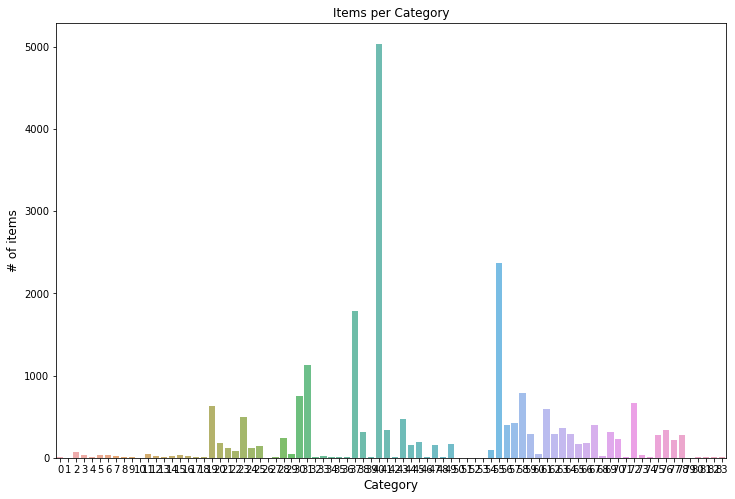

In [32]:
plt.figure(figsize=(12,8))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

In [ ]:
# 

# shop

In [141]:
shop = pd.read_csv("../input/shops.csv")

#print(shop.info())
#display(shop.head(2))

shop["shop_name_size"] = shop["shop_name"].map(len)

shop["city"] = shop["shop_name"]
ng_list = ['"', ',', "(", ")", ".", "?", "!", "-"] + [str(i) for i in list(range(10))]
for ng_char in ng_list:
    shop["city"] = shop["city"].map(lambda x: x.replace(ng_char, ''))
shop["city"] = shop["city"].map(lambda x: x.split(" ")[0])

city_list = list(set(shop["city"]))
shop["city_id"] = shop["city"].map(lambda x: city_list.index(x))

shop = shop.drop(["shop_name", "city"], axis = 1)

shop = shop.set_index('shop_id')

display(shop)

,shop_name_size,city_id
shop_id,,
0,29,0
1,29,0
2,16,10
3,30,12
4,24,19
5,22,14
6,26,15
7,22,15
8,28,15


# item & item categories

In [128]:
item = pd.read_csv("../input/items.csv")
category = pd.read_csv("../input/item_categories.csv")
#print(item.info())
#print(category.info())

#display(item)
#display(category)

# item_nameを数値データに変換し、除外する
item["item_name_size"] = item["item_name"].map(len)
item = item.drop("item_name", axis = 1)

# item_category_nameを数値データに変換し、除外する
category["category_name_size"] = category["item_category_name"].map(len)
category = category.drop(["item_category_id", "item_category_name"], axis = 1)

# categoryをitemに統合する
item["category_name_size"] = item["item_category_id"].map(lambda x : category.iloc[x, 0])

item = item.set_index('item_id')

display(item)
#display(category)

,item_category_id,item_name_size,category_name_size
item_id,,,
0,40,41,10
1,76,68,36
2,40,45,10
3,40,47,10
4,40,43,10
...,...,...,...
22165,31,38,15
22166,54,47,13
22167,49,53,33


# train & test

In [149]:
train = pd.read_csv("../input/sales_train.csv")
test = pd.read_csv("../input/test.csv")

# trainの全データから、testに存在するitemとshopだけを抽出
train_shop_bool = train.shop_id.isin(test.shop_id.unique())
train_item_bool = train.item_id.isin(test.item_id.unique())
train = train[train_shop_bool & train_item_bool]

# date → month, year (submit の単位が item_cnt_month なので day は不要)
train['month'] = train.date.apply(lambda x: int(x.split(".")[1]))
train['year'] = train.date.apply(lambda x: int(x.split(".")[2]))
train = train.drop("date", axis = 1)

# item を train に統合
train = train.set_index('item_id')#item_idを行indexにして並べなおす
train = train.join(item)
train = train.reset_index()

# shop を train に統合
train = train.set_index('shop_id')#item_idを行indexにして並べなおす
train = train.join(shop)
train = train.reset_index()

display(train)
display(test)

,shop_id,item_id,date_block_num,item_price,item_cnt_day,month,year,item_category_id,item_name_size,category_name_size,shop_name_size,city_id
0,2,30,2,359.0,1.0,3,2013,40,26,10,16,10
1,2,30,5,399.0,1.0,6,2013,40,26,10,16,10
2,2,30,15,169.0,1.0,4,2014,40,26,10,16,10
3,2,30,16,169.0,1.0,5,2014,40,26,10,16,10
4,2,31,1,699.0,1.0,2,2013,37,31,14,16,10
...,...,...,...,...,...,...,...,...,...,...,...,...
1224434,59,22164,30,699.0,1.0,7,2015,37,11,14,22,26
1224435,59,22167,9,299.0,1.0,10,2013,49,53,33,22,26
1224436,59,22167,11,299.0,1.0,12,2013,49,53,33,22,26
1224437,59,22167,11,299.0,1.0,12,2013,49,53,33,22,26


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [161]:
train = train.groupby(['shop_id'
                             , 'item_id'
                             #, 'date_block_num'
                             , 'month'
                             , 'year']).sum()
train.head()

date_block_num  item_price  item_cnt_day  \
shop_id item_id month year                                             
2       30      3     2013               2   -0.299895     -0.252069   
                4     2014              15   -0.299899     -0.252069   
                5     2014              16   -0.299899     -0.252069   
                6     2013               5   -0.299894     -0.252069   
        31      2     2013               4   -1.199553     -1.008276   

                            item_category_id  item_name_size  \
shop_id item_id month year                                     
2       30      3     2013                40              26   
                4     2014                40              26   
                5     2014                40              26   
                6     2013                40              26   
        31      2     2013               148             124   

                            category_name_size  shop_name_size  city_id  
shop_id item_id month year                                               
2       30      3     2013                  10              16       10  
                4     2014                  10              16       10  
                5     2014                  10              16       10  
                6     2013                  10              16       10  
        31      2     2013                  56              64       40

# 月ごとの売り上げ合計を可視化

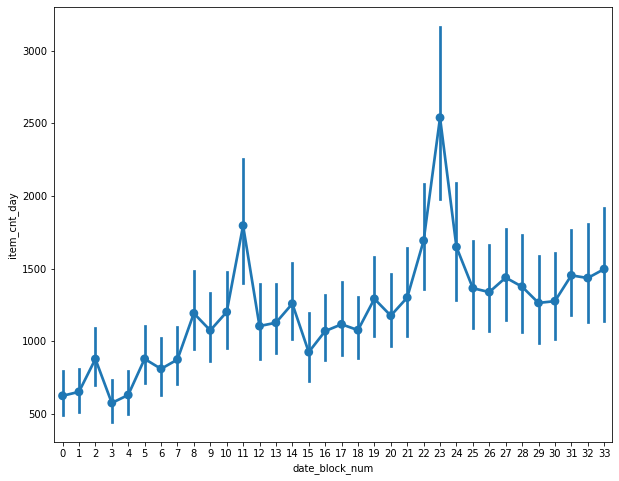

In [145]:
grouped = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
#display(grouped)

fig, ax = plt.subplots(figsize = (10,8))
sns.pointplot(x = 'date_block_num'
              , y = 'item_cnt_day'
              #, hue = 'shop_id'
              , data=grouped)
plt.show()

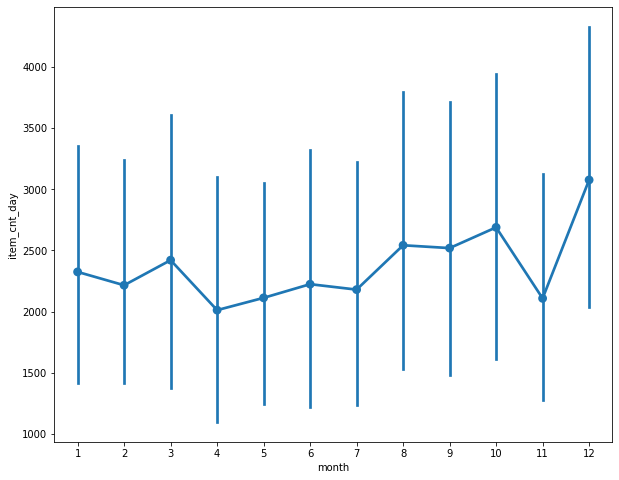

In [146]:
grouped = pd.DataFrame(train.groupby(['month', 'item_category_id'])['item_cnt_day'].sum().reset_index())
#display(grouped)

fig, axes = plt.subplots(figsize=(10,8))
sns.pointplot(x = 'month'
              , y = 'item_cnt_day'
              #, hue = 'item_category_id'
              , data = grouped
              )
plt.show()

# 正規化

 - item_price 
 - item_cnt_day
 
を正規化

In [162]:
scaler = StandardScaler()
cnt_scaler = StandardScaler()

scaler.fit(train.item_price.values.reshape(-1, 1))
cnt_scaler.fit(train.item_cnt_day.values.reshape(-1, 1))

train.item_price = scaler.transform(train.item_price.values.reshape(-1, 1))
train.item_cnt_day = cnt_scaler.transform(train.item_cnt_day.values.reshape(-1, 1))

train

date_block_num  item_price  item_cnt_day  \
shop_id item_id month year                                             
2       30      3     2013               2    0.447879      0.459732   
                4     2014              15    0.447874      0.459732   
                5     2014              16    0.447874      0.459732   
                6     2013               5    0.447881      0.459732   
        31      2     2013               4   -0.843919     -0.892698   
...                                    ...         ...           ...   
59      22164   4     2015              54    0.017287      0.008922   
                7     2015              30    0.447889      0.459732   
        22167   6     2014              17    0.447878      0.459732   
                10    2013               9    0.447878      0.459732   
                12    2013              22    0.017263      0.008922   

                            item_category_id  item_name_size  \
shop_id item_id month year                                     
2       30      3     2013                40              26   
                4     2014                40              26   
                5     2014                40              26   
                6     2013                40              26   
        31      2     2013               148             124   
...                                      ...             ...   
59      22164   4     2015                74              22   
                7     2015                37              11   
        22167   6     2014                49              53   
                10    2013                49              53   
                12    2013                98             106   

                            category_name_size  shop_name_size  city_id  
shop_id item_id month year                                               
2       30      3     2013                  10              16       10  
                4     2014                  10              16       10  
                5     2014                  10              16       10  
                6     2013                  10              16       10  
        31      2     2013                  56              64       40  
...                                        ...             ...      ...  
59      22164   4     2015                  28              44       52  
                7     2015                  14              22       26  
        22167   6     2014                  33              22       26  
                10    2013                  33              22       26  
                12    2013                  66              44       52  

[600159 rows x 8 columns]

In [165]:
train.reset_index().groupby(['item_id', 'date_block_num', 'shop_id']).mean()

month    year  item_price  item_cnt_day  \
item_id date_block_num shop_id                                            
30      1              12         2.0  2013.0    0.447881      0.459732   
        2              2          3.0  2013.0    0.447879      0.459732   
                       14         3.0  2013.0    0.447881      0.459732   
                       18         3.0  2013.0    0.447881      0.459732   
                       41         2.0  2013.0    0.017269      0.008922   
...                               ...     ...         ...           ...   
22167   250            22         2.0  2015.0   -3.427653     -3.569495   
        270            22         4.0  2015.0   -3.427653     -3.569495   
        308            22         5.0  2015.0   -3.858267     -4.006273   
        330            22        11.0  2014.0   -5.580725     -5.781450   
        363            22        10.0  2015.0   -3.858268     -4.006273   

                                item_category_id  item_name_size  \
item_id date_block_num shop_id                                     
30      1              12                   40.0            26.0   
        2              2                    40.0            26.0   
                       14                   40.0            26.0   
                       18                   40.0            26.0   
                       41                   80.0            52.0   
...                                          ...             ...   
22167   250            22                  490.0           530.0   
        270            22                  490.0           530.0   
        308            22                  539.0           583.0   
        330            22                  735.0           795.0   
        363            22                  539.0           583.0   

                                category_name_size  shop_name_size  city_id  
item_id date_block_num shop_id                                               
30      1              12                     10.0            19.0     22.0  
        2              2                      10.0            16.0     10.0  
                       14                     10.0            23.0     21.0  
                       18                     10.0            20.0      2.0  
                       41                     20.0            44.0     48.0  
...                                            ...             ...      ...  
22167   250            22                    330.0           180.0     50.0  
        270            22                    330.0           180.0     50.0  
        308            22                    363.0           198.0     55.0  
        330            22                    495.0           270.0     75.0  
        363            22                    363.0           198.0     55.0  

[581122 rows x 9 columns]

# Missing data

上記の時間帯に全てのアイテムが販売されているわけではありませんので、item_cnt_dayを0にしてレコードを追加

In [166]:
price = train.reset_index().set_index(['item_id', 'shop_id', 'date_block_num'])
price = price.sort_index()
price

# 商品の価格はお店や時間帯によって異なることが分かる

# 空の値は過去のレコードの中で一番近いもので埋める

month  year  item_price  item_cnt_day  \
item_id shop_id date_block_num                                          
30      2       2                   3  2013    0.447879      0.459732   
                5                   6  2013    0.447881      0.459732   
                15                  4  2014    0.447874      0.459732   
                16                  5  2014    0.447874      0.459732   
        3       4                   2  2013   -0.843954     -0.892698   
...                               ...   ...         ...           ...   
22167   58      14                  3  2014    0.447878      0.459732   
                20                  9  2014    0.447878      0.459732   
        59      9                  10  2013    0.447878      0.459732   
                17                  6  2014    0.447878      0.459732   
                22                 12  2013    0.017263      0.008922   

                                item_category_id  item_name_size  \
item_id shop_id date_block_num                                     
30      2       2                             40              26   
                5                             40              26   
                15                            40              26   
                16                            40              26   
        3       4                            160             104   
...                                          ...             ...   
22167   58      14                            49              53   
                20                            49              53   
        59      9                             49              53   
                17                            49              53   
                22                            98             106   

                                category_name_size  shop_name_size  city_id  
item_id shop_id date_block_num                                               
30      2       2                               10              16       10  
                5                               10              16       10  
                15                              10              16       10  
                16                              10              16       10  
        3       4                               40             120       48  
...                                            ...             ...      ...  
22167   58      14                              33              23        0  
                20                              33              23        0  
        59      9                               33              22       26  
                17                              33              22       26  
                22                              66              44       52  

[600159 rows x 9 columns]

In [168]:
def convert(date_block):
    """
    convert from date_block_num to month, year
        ex1 convert(6)  : (7, 2013)
        ex2 convert(18) : (7, 2014)
        ex3 convert(30) : (7, 2015)
    """
    date = datetime(2013, 1, 1)
    date += relativedelta(months = date_block)
    return (date.month, date.year)

def closest_date_block(current_day, item_id, shop_id):
    """
    Find the block_date which is closest to the current_day, given item_id and shop_id.
    Returns index integer
    """
    if (item_id, shop_id) in price.index:
        search_lst = np.array(price.loc[(item_id, shop_id)].index)        
        return search_lst[np.abs(current_day - search_lst).argmin()]
    return -1
                
def closest_price(current_day, item_id, shop_id):
    closest_date = closest_date_block(current_day, item_id, shop_id)
    if closest_date != -1:
        return price.loc[( item_id, shop_id, closest_date )]['item_price']
    return np.nan

def closest_price_lambda(x):
    return closest_price(34, x.item_id, x.shop_id)

In [ ]:
# assertはデバッグ用の関数。try exceptの代わりに書ける。条件式がFalseならエラーを出す
assert closest_date_block(18, 30, 5) == 18

In [171]:
maxlen = 4 # 4 months
step = 1
sentences = [[],[],[]] # 0: train, 1: val, 2:test
next_chars = [[], []]
BLOCKS = [6, 18, 30]

for s in test_shops:
    shop_items = list(train.loc[s].index.get_level_values(0).unique())
    for it in shop_items:        
        for i_index, i in enumerate(BLOCKS):
            sentence, closest_pc = [], closest_price(i, it, s)      
            for j in range(maxlen+1):
                if j < maxlen:
                    if (s, it, i+j) in train.index:
                        month, year = convert(i+j)
                        r = train.loc[(s, it, i + j)].to_dict(orient='list')                    
                        closest_pc = r['item_price'][0]
                        item_cnt_day = r['item_cnt_day'][0]
                        row = {'shop_id': s
                               , 'date_block_num': i+j
                               , 'item_cnt_day': item_cnt_day
                               , 'month': month
                               , 'item_id': it
                               , 'item_price': closest_pc
                               , 'year': year}
                    else:
                        month, year = convert(i+j)                    
                        row = {'shop_id': s
                               , 'date_block_num': i+j
                               , 'item_cnt_day': 0
                               , 'month': month
                               , 'item_id': it
                               , 'item_price': closest_pc
                               , 'year': year}
                    sentence.append(row)
                elif i_index < 2:   # not in test set
                    next_chars[i_index].append(row)
            sentences[i_index].append(sentence)

KeyboardInterrupt: 

In [ ]:
x_train_o = np.array(sentences[0])
x_val_o = np.array(sentences[1])
x_test_o = np.array(sentences[2])
y_train = np.array([x['item_cnt_day'] for x in next_chars[0]])
y_val = np.array([x['item_cnt_day'] for x in next_chars[1]])

In [ ]:
length = MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 + 1 + 1

In [ ]:
shop_le = preprocessing.LabelEncoder()
shop_le.fit(test_shops)
shop_dm = dict(zip(test_shops, shop_le.transform(test_shops)))

item_le = preprocessing.LabelEncoder()
item_le.fit(test_items)
item_dm = dict(zip(test_items, item_le.transform(test_items)))

month_le = preprocessing.LabelEncoder()
month_le.fit(range(7,11))
month_dm = dict(zip(range(7,11), month_le.transform(range(7,11))))

#cat_le = preprocessing.LabelEncoder()
#cat_le.fit(item_cats.item_category_id)
#cat_dm = dict(zip(item_cats.item_category_id.unique(), cat_le.transform(item_cats.item_category_id.unique())))

In [ ]:
def vectorize(inp):
    x = np.zeros((len(inp), maxlen, length), dtype=np.float32)
    for i, sentence in enumerate(inp):
        for t, char in enumerate(sentence):            
            x[i][t][ shop_dm[char['shop_id']] ] = 1        
            x[i][t][ MAX_SHOP + item_dm[char['item_id']] ] = 1
            x[i][t][ MAX_SHOP + MAX_ITEM + month_dm[char['month']] ] = 1
            x[i][t][ MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 ] = char['item_price']
            x[i][t][ MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 + 1] = char['item_cnt_day']    
    return x

In [ ]:
x_train = vectorize(x_train_o)
x_val = vectorize(x_val_o)
x_test = vectorize(x_test_o)

In [ ]:
# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(32, input_shape=(maxlen, length)))
model.add(Dense(1, activation='relu'))

optimizer = RMSprop(lr=0.005)
model.compile(loss='mean_squared_error', optimizer=optimizer)

model.fit(x_train, y_train, batch_size=128, epochs=13)

# make predictions
predict_train = model.predict(x_train)
predict_val = model.predict(x_val)

# invert predictions
predict_train = cnt_scaler.inverse_transform(predict_train)
y_train = cnt_scaler.inverse_transform(y_train)
predict_val = cnt_scaler.inverse_transform(predict_val)
y_val = cnt_scaler.inverse_transform(y_val)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(predict_train, y_train))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(predict_val, y_val))
print('Test Score: %.2f RMSE' % (valScore))

model.fit(x_val, y_val, batch_size=128, epochs=13)

# Inference (推論)

In [ ]:
predict_test = model.predict(x_test)
predict_test = cnt_scaler.inverse_transform(predict_test)

test = test.set_index(['shop_id', 'item_id'])
test['item_cnt_month'] = 0

for index, sentence in enumerate(x_test_o):
    (shop_id, item_id) = (sentence[0]['shop_id'], sentence[0]['item_id'])
    test.loc[(shop_id, item_id)]['item_cnt_month'] = predict_test[index]
    
test = test.reset_index().drop(['shop_id', 'item_id'], axis=1)
test.to_csv('submission.csv', index=False)